# P3LTR runbook

In this notebook we run and save P3LTR recommendations according to the best known model configuration.

## Loading libraries and setting parameters

In [1]:
import sys
from time import time
from functools import partial
from multiprocessing.pool import ThreadPool
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import normalize
from tqdm import tqdm
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import pickle

sys.path.append("../../..")
from src.common import config
from src.evaluation.evaluator import Evaluator
from src.data.initializer import DataLoaderSaver
from src.models.base import BaseRecommender
from src.models.p3ltr import P3LTR

%load_ext autoreload

Using backend: pytorch


In [2]:
MODEL_NAME = "P3LTR-notebook-3rd"

paths = config.Paths(
    dataset_name="jobs_published",
    target_users_name="all",
    model_name=MODEL_NAME,
)

N_RECOMMENDATIONS = 10

## Model training

In [ ]:
%%time

model = P3LTR(
    learning_rate=0.1,
    regularization=0.1,
    batch_size=100,
    iterations=50,
    top_k=10,
    user_selection="deterministic",
    loss="log_ratio"
)

model.load_interactions(paths.train_and_validation)

model.preprocess()

model.fit()

### Check training evolution

array([<AxesSubplot:xlabel='iteration'>, <AxesSubplot:xlabel='iteration'>,
       <AxesSubplot:xlabel='iteration'>], dtype=object)

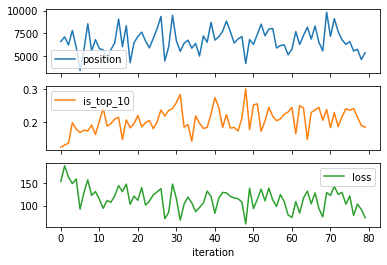

In [4]:
pos = model.trainer.monitoring_metrics["val_node_positions"]
pos["is_top_10"] = pos["position"] < 10
training_results = pos.groupby(["iteration"]).mean()
training_results["loss"] = pd.Series(model.trainer.monitoring_metrics["losses"])

display(training_results.plot(subplots=True))

In [5]:
for i in range(3):
    print(list(model.trainer.feature_encoders[i].parameters()), '\n\n')

[Parameter containing:
tensor([[0.6313]], requires_grad=True), Parameter containing:
tensor([[0.0813]], requires_grad=True), Parameter containing:
tensor([[ 0.1179, -0.0528, -0.1417,  0.0231,  0.0085,  0.0395,  0.0170,  0.0038]],
       requires_grad=True), Parameter containing:
tensor([-0.0108], requires_grad=True), Parameter containing:
tensor([[0.0856]], requires_grad=True), Parameter containing:
tensor([0.1707], requires_grad=True)] 


[Parameter containing:
tensor([[0.1626]], requires_grad=True), Parameter containing:
tensor([[0.0082]], requires_grad=True), Parameter containing:
tensor([[-0.9306,  0.0871,  0.4095,  0.4407,  0.3753,  0.2258, -0.0028, -0.0140]],
       requires_grad=True), Parameter containing:
tensor([-0.6368], requires_grad=True), Parameter containing:
tensor([[-0.7417]], requires_grad=True), Parameter containing:
tensor([-0.5833], requires_grad=True)] 


[Parameter containing:
tensor([[0.4331]], requires_grad=True), Parameter containing:
tensor([[0.0283]], requir

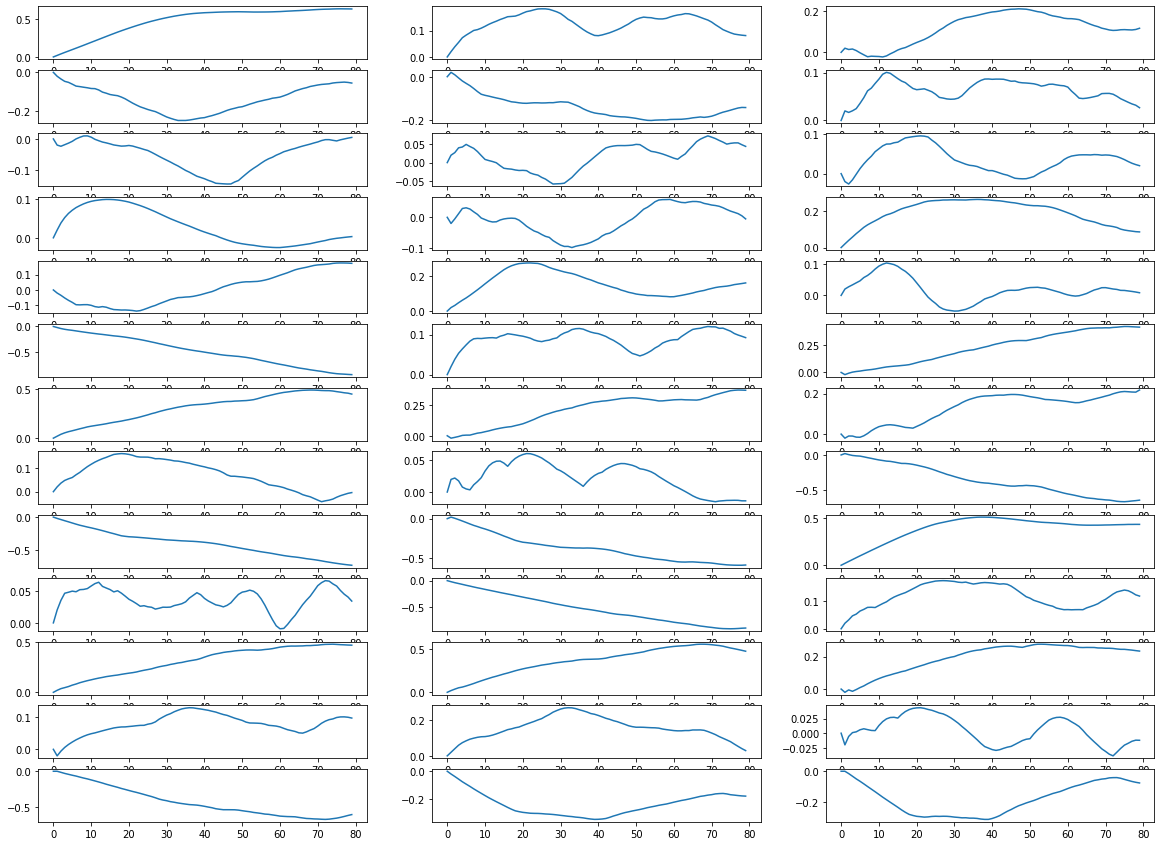

In [6]:
nb_params = model.trainer.monitoring_metrics["parameter_change_history"].shape[0]
fig, axs = plt.subplots((nb_params+2)//3, 3, figsize=(20,15))
pos_x, pos_y = 0, 0
for nb_param in range(nb_params):
    axs[pos_x, pos_y].plot(pd.Series(model.trainer.monitoring_metrics["parameter_change_history"][nb_param, :]))
    
    if pos_y < 2:
        pos_y += 1
    else:
        pos_y = 0
        pos_x += 1

## Generating recommendations

In [7]:
target_users = model.load_target_users(paths.target_users)

recommendations = model.recommend(
    target_users=target_users, n_recommendations=N_RECOMMENDATIONS
)

model.save_recommendations(recommendations, paths.recommendations)

619389it [13:04, 789.86it/s]


## Evaluation

In [8]:
evaluator = Evaluator(
    recommendations_path=paths.recommendations_folder,
    test_path=paths.test,
    k=10,
    models_to_evaluate=[MODEL_NAME],
)

evaluator.prepare()

evaluator.evaluate_models()

619389it [00:48, 12642.23it/s]


In [9]:
evaluator.evaluation_results

,precision,recall,F_1,F_05,ndcg,mAP,MRR,LAUC,HR,reco_in_test,test_coverage,Shannon,Gini,users_without_reco,users_without_k_reco
model_name,,,,,,,,,,,,,,,
P3LTR-notebook-3rd,0.0515,0.081697,0.049337,0.047751,0.079792,0.041435,0.142294,0.540812,0.3242,0.994152,0.757477,10.089593,0.844423,0.000402,0.000488
